# TF Tau Finder

In [1]:
# fullwidth notebook cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# suppress tensorflow FutureWarning
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import h5py
import tensorflow as tf

# for reading & slicing data
import pandas as pd

# for data preprocessing
from sklearn.preprocessing import MinMaxScaler

import numpy as np

/Users/andrew/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/andrew/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/andrew/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/andrew/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


***

## Load data

In [3]:
data_path = 'wrap_data_test_1.csv'
data_df = pd.read_csv(data_path, dtype = float)

In [4]:
data_df.head()

,tau,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,4.263624,2.678914,2.681533,2.684151,2.686770,2.689389,2.692007,2.694626,2.697245,2.699863,...,-0.948926,-0.946307,-0.943688,-0.941069,-0.938451,-0.935832,-0.933213,-0.930595,-0.927976,-0.925357
1,30.689476,0.433210,0.452059,0.470909,0.489758,0.508607,0.527456,0.546306,0.565155,0.584004,...,0.696777,0.715627,0.734476,0.753325,0.772174,0.791024,0.809873,0.828722,0.847571,0.866421
2,77.284880,-1.705960,-1.658493,-1.611025,-1.563557,-1.516089,-1.468621,-1.421154,-1.373686,-1.326218,...,2.444055,2.491523,2.538990,2.586458,2.633926,2.681394,2.728861,2.776329,2.823797,2.871265
3,-21.807557,-1.135722,-1.149116,-1.162510,-1.175904,-1.189298,-1.202692,-1.216086,-1.229480,-1.242874,...,-2.150897,-2.164291,-2.177685,-2.191079,-2.204473,-2.217867,-2.231261,-2.244655,-2.258049,-2.271444
4,39.138534,-0.541275,-0.517237,-0.493198,-0.469159,-0.445121,-0.421082,-0.397044,-0.373005,-0.348967,...,-1.298898,-1.274859,-1.250820,-1.226782,-1.202743,-1.178705,-1.154666,-1.130628,-1.106589,-1.082550


### Seperate data into training and testing

In [5]:
# Randomly sample 80%
training_data_df = data_df.sample(frac = 0.8)

In [6]:
testing_data_df = data_df.loc[~data_df.index.isin(training_data_df.index)]

#### Truncate data for experimentation

In [7]:
training_short_df = training_data_df.loc[:, :'1023']

In [8]:
testing_short_df = testing_data_df.loc[:, :'1023']

### Split the data into X and Y

In [9]:
# drop the tau column from the X data (data to train with)
# axis = 1 drops the column
X_training = training_short_df.drop('tau', axis = 1).values

# retain only the tau column (value to predict) for the Y data
Y_training = training_short_df[['tau']].values

In [10]:
# drop the tau column from the X data (data to train with)
# axis = 1 drops the column
X_testing = testing_short_df.drop('tau', axis = 1).values

# retain only the tau column (value to predict) for the Y data
Y_testing = testing_short_df[['tau']].values

In [11]:
# Create scalars for inputs and outputs
X_scaler = MinMaxScaler(feature_range = (0,1))
Y_scaler = MinMaxScaler(feature_range = (0,1))

In [12]:
# Scale training input and output
X_scaled_training = X_scaler.fit_transform(X_training)
Y_scaled_training = Y_scaler.fit_transform(Y_training)

In [13]:
# Scale testing data using same scaler
X_scaled_testing = X_scaler.transform(X_testing)
Y_scaled_testing = Y_scaler.transform(Y_testing)

In [14]:
msg = 'Note: Y values were scaled by multiplying by {:.10f} and adding {:.4f}'
print(msg.format(Y_scaler.scale_[0], Y_scaler.min_[0]))

Note: Y values were scaled by multiplying by 0.0050009846 and adding 0.4999


In [15]:
# Define how many inputs and outputs are in our neural network
number_of_inputs = X_scaled_training.shape[1]
number_of_outputs = Y_scaled_training.shape[1]

In [16]:
# define how many neurons we want in each layer of our NN
layer_1_nodes = 500
layer_2_nodes = 50
layer_3_nodes = 250

In [17]:
# Define model parameters
learning_rate = 0.0015
training_epochs = 500
display_step = 2

In [18]:
# Input Layer
with tf.variable_scope('input'):
    X  = tf.placeholder(tf.float32, shape = (None, number_of_inputs))
    
# Layer 1
with tf.variable_scope('layer_1'):
    
    biases = tf.get_variable(name = "biases1",
                             shape = [layer_1_nodes],
                             initializer = tf.zeros_initializer())
    
    weights = tf.get_variable(name = "weights1",
                              shape  = [number_of_inputs, layer_1_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_1_output = tf.nn.relu(tf.matmul(X, weights) + biases)
    
# Layer 2
with tf.variable_scope('layer_2'):
    
    biases = tf.get_variable(name = "biases2",
                             shape = [layer_2_nodes],
                             initializer = tf.zeros_initializer())
    
    weights = tf.get_variable(name = "weights2",
                              shape  = [layer_1_nodes, layer_2_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_2_output = tf.nn.relu(tf.matmul(layer_1_output, weights) + biases)
    
# Layer 3
with tf.variable_scope('layer_3'):
    
    biases = tf.get_variable(name = "biases3",
                             shape = [layer_3_nodes],
                             initializer = tf.zeros_initializer())
    
    weights = tf.get_variable(name = "weights3",
                              shape  = [layer_2_nodes, layer_3_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_3_output = tf.nn.relu(tf.matmul(layer_2_output, weights) + biases)
    
# Output layer

with tf.variable_scope('output'):
    
    biases = tf.get_variable(name = "biases_out",
                             shape = [number_of_outputs],
                             initializer = tf.zeros_initializer())
    
    weights = tf.get_variable(name = "weights_out",
                              shape  = [layer_3_nodes, number_of_outputs],
                         initializer = tf.contrib.layers.xavier_initializer())


    prediction = tf.nn.relu(tf.matmul(layer_3_output, weights) + biases)
    
with tf.variable_scope('cost'):
    
    Y = tf.placeholder(tf.float32, shape = (None, 1))
    cost = tf.reduce_mean(tf.squared_difference(prediction, Y))

    
with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-05).minimize(cost)
    
with tf.variable_scope('logging'):
    tf.summary.scalar('current_cost', cost)
    summary = tf.summary.merge_all()
    
saver = tf.train.Saver()

/Users/andrew/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [19]:
# initialize a session to run TF operations
with tf.Session() as session:
    
    # Run the global variable initilizer to init all variables and layers
    session.run(tf.global_variables_initializer())
    
    # Create log writers to record training progress
    # Store training and testing data separately
    training_writer = tf.summary.FileWriter('logs2-200-100-50/training', session.graph)
    testing_writer = tf.summary.FileWriter('logs2-200-100-50/testing', session.graph)
    
    
    # Run the optimizer over and over to train the network
    # One epoch is one full run through the training data set
    for epoch in range(training_epochs):
        
        # Feed in the training data and do one stepf NN training
        session.run(optimizer,
                    feed_dict = {X: X_scaled_training, Y: Y_scaled_training})

        # Every display_step steps, log our process
        if epoch % display_step == 0:
            
            training_feed = {X: X_scaled_training, Y: Y_scaled_training}
            training_cost, training_summary = session.run([cost, summary],
                                                    feed_dict = training_feed)
            
            testing_feed =  {X: X_scaled_testing, Y: Y_scaled_testing}
            testing_cost, testing_summary = session.run([cost, summary],
                                                     feed_dict = testing_feed)
            
            print(epoch, training_cost, testing_cost)
            
            # write the current status to the log files
            training_writer.add_summary(training_summary, epoch)
            testing_writer.add_summary(testing_summary, epoch)
            
    print('Training done')
    
    final_training_cost = session.run(cost,
                                      feed_dict = {X: X_scaled_training,
                                                   Y: Y_scaled_training})
    
    final_testing_cost = session.run(cost,
                                     feed_dict = {X: X_scaled_testing,
                                                  Y: Y_scaled_testing})

    print('Final Training Cost: {}'.format(final_training_cost))
    print('Final Testing Cost: {}'.format(final_testing_cost))
    
    
    # Now that the NN is trained, lets use it to make predictions.
    # pass in the X testing data and run the prediction operation
    Y_prediction_scaled = session.run(prediction,
                                      feed_dict = {X:X_scaled_testing})

    # Unscale the data back to its original units (dollar$)
    Y_predicted = Y_scaler.inverse_transform(Y_prediction_scaled)
    
    rand_entry = np.random.randint(0,200)
    # actual earnings of 0th game
    real_tau = testing_short_df['tau'].values[rand_entry]
    
    # predicted_earnings of 0th game
    predicted_earnings = Y_predicted[rand_entry][0]
    
    print('The actual tau of row #1 is {}'.format(real_tau))
    
    msg = 'The predicted tau of row #1 is {}'
    print(msg.format(predicted_earnings))
    
    model_save_location = "logs2-200-100-50/trained_model.ckpt"
    save_path = saver.save(session, model_save_location)
    print('Model saved: {}'.format(save_path))

0 3.4394708 3.4525616
2 0.2221378 0.22090945
4 0.17295608 0.17479734
6 0.086540215 0.08716635
8 0.12369243 0.12354616
10 0.102052994 0.10355118
12 0.089152016 0.09021726
14 0.10127765 0.10148655
16 0.08545762 0.086324066
18 0.09198695 0.09312404
20 0.08917348 0.08945685
22 0.08653064 0.086894885
24 0.09003136 0.090971544
26 0.084953554 0.08546716
28 0.08738115 0.0877236
30 0.08676002 0.08756121
32 0.08502172 0.08568152
34 0.08649927 0.08693561
36 0.08534468 0.086115904
38 0.084951796 0.085681245
40 0.08561261 0.08609664
42 0.08476634 0.085478775
44 0.08470953 0.085438244
46 0.08499448 0.08556158
48 0.08451996 0.08528092
50 0.08442413 0.085166246
52 0.08455653 0.08512929
54 0.08429546 0.085003875
56 0.08412814 0.08483504
58 0.08420045 0.08484115
60 0.08406703 0.08484072
62 0.08390131 0.08458972
64 0.08386859 0.08453554
66 0.08381439 0.084606886
68 0.083683014 0.08442253
70 0.08356514 0.084332645
72 0.08350029 0.08431772
74 0.08341208 0.08419373
76 0.08329255 0.08414981
78 0.083172254 0.

In [20]:
real_tau_ten = testing_short_df['tau'].values[0:10]
predicted_earnings_ten = Y_predicted[0:10].T[0]
print(real_tau_ten)
print(predicted_earnings_ten)

[-21.80755732  82.53084872 -46.78979372 -43.89086084  58.73071152
 -15.38806819  98.32728659 -70.42693694 -81.58667937  69.51098874]
[-24.785357   89.1554    -33.131634  -33.74062    50.584427   -4.2343297
 101.16482   -55.4731    -83.00259    69.4577   ]


In [21]:
import matplotlib.pyplot as plt

In [22]:
sort_idx = np.argsort(testing_short_df['tau'].values)

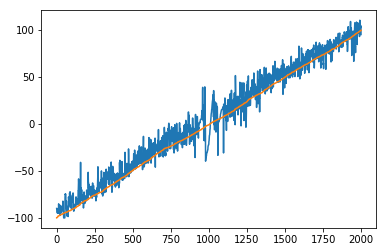

In [23]:
plt.plot(Y_predicted[:].T[0][sort_idx][::])
plt.plot(testing_short_df['tau'].values[sort_idx][::])
plt.show()